In [171]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from scipy.stats import norm
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor 
import statsmodels.api as sm
from patsy import dmatrices
from sklearn.linear_model import LinearRegression
import sklearn.linear_model as linear_model
import math
from scipy import stats as st

%matplotlib inline

In [147]:
# Read in the training data
df_train = pd.read_csv('C:/Users/Admin/Documents/Kaggle/HousePriceRegression/train.csv')
# df_train.head()
# list(df_train)

# Get quantative and qualitative variables
quantitative = [f for f in df_train.columns if df_train.dtypes[f] != 'object']
qualitative = [f for f in df_train.columns if df_train.dtypes[f] == 'object']
quantitative.remove('SalePrice')
quantitative.remove('Id')

df_train_all = df_train

Understand the problem. We'll look at each variable and do a philosophical analysis about their meaning and importance for this problem.
Univariable study. We'll just focus on the dependent variable ('SalePrice') and try to know a little bit more about it.
Multivariate study. We'll try to understand how the dependent variable and independent variables relate.
Basic cleaning. We'll clean the dataset and handle the missing data, outliers and categorical variables.
Test assumptions. We'll check if our data meets the assumptions required by most multivariate techniques

Create Excel spreadsheet for analysis
Variable - Variable name.
Type - Identification of the variables' type. There are two possible values for this field: 'numerical' or 'categorical'. By 'numerical' we mean variables for which the values are numbers, and by 'categorical' we mean variables for which the values are categories.

Segment - Identification of the variables' segment. We can define three possible segments: building, space or location. When we say 'building', we mean a variable that relates to the physical characteristics of the building (e.g. 'OverallQual'). When we say 'space', we mean a variable that reports space properties of the house (e.g. 'TotalBsmtSF'). Finally, when we say a 'location', we mean a variable that gives information about the place where the house is located (e.g. 'Neighborhood').
Expectation - Our expectation about the variable influence in 'SalePrice'. We can use a categorical scale with 'High', 'Medium' and 'Low' as possible values.
Conclusion - Our conclusions about the importance of the variable, after we give a quick look at the data. We can keep with the same categorical scale as in 'Expectation'.
Comments - Any general comments that occured to us.

In [135]:
#descriptive statistics summary
df_train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


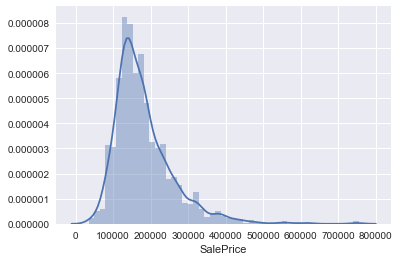

In [136]:
#histogram
sns.distplot(df_train['SalePrice']);

In [137]:
#skewness and kurtosis
print("Skewness: %f" % df_train['SalePrice'].skew())
print("Kurtosis: %f" % df_train['SalePrice'].kurt())

Skewness: 1.882876
Kurtosis: 6.536282


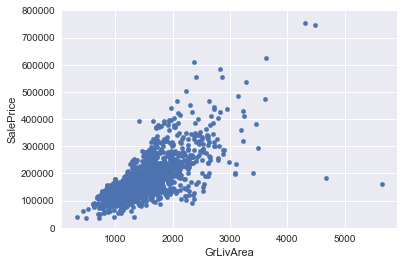

In [138]:
#scatter plot grlivarea/saleprice
var = 'GrLivArea'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

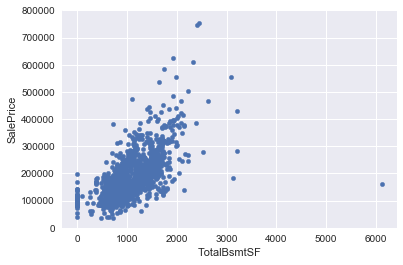

In [139]:
#scatter plot totalbsmtsf/saleprice
var = 'TotalBsmtSF'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000))

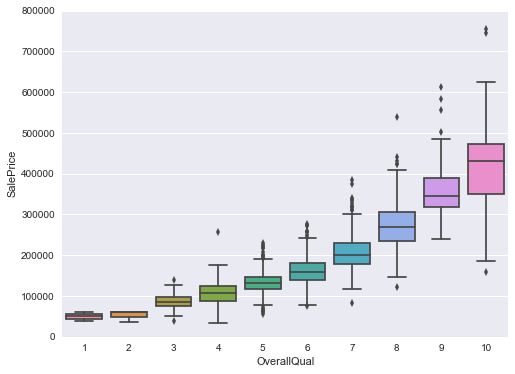

In [140]:
#box plot overallqual/saleprice
var = 'OverallQual'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);

### Collinearity

Collinearity may increase the standard errors. We can see potential colinearity in variables with a correlation of greater than +/- 0.7

If two features are co-linear then there are two solutions:

1) Ignore one of the variables
2) Create another variable out of the two variables. 

##### Variance Inflation Function
Look into VIF as better way of analysing for multi-colinear features.
A VIF of 5 or 10 and above indicates a multicollinearity problem.

https://etav.github.io/python/vif_factor_python.html

In [141]:
# This drops all columns that have an NaN
df_train_numeric = df_train.dropna(axis = 1)
df_train_numeric= df_train_numeric._get_numeric_data()


# Rename columns starting with a numeric as this seems to cause an issue in dmatrices
df_train_numeric.rename( columns={"1stFlrSF": "FirstFlrSq", "2ndFlrSF": "SndFlrSq", "3SsnPorch": "ThirdSsnPorch"}, inplace =True)


# list out the column names and do a join
features = list(df_train_numeric)
features = "+".join(features[1:])

# get y and X dataframes based on this regression:
y, X = dmatrices('SalePrice ~' + features, df_train_numeric, return_type='dataframe')

# For each X, calculate VIF and save in dataframe
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["Features"] = X.columns

# Drop columns where the VIF is greater than 5
df_train.drop(['BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','1stFlrSF','2ndFlrSF','LowQualFinSF','GarageCars'], axis = 1, inplace=True)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


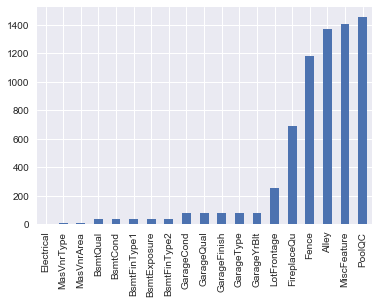

In [142]:
# bar plot of missing data
missing = df_train.isnull().sum()
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.bar()

In [10]:
#missing data
total = df_train.isnull().sum().sort_values(ascending=False)
percent = (df_train.isnull().sum()/df_train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageCond,81,0.055479
GarageType,81,0.055479
GarageYrBlt,81,0.055479
GarageFinish,81,0.055479


In [11]:
#dealing with missing data
df_train = df_train.drop((missing_data[missing_data['Total'] > 1]).index,1)
df_train = df_train.drop(df_train.loc[df_train['Electrical'].isnull()].index)
df_train.isnull().sum().max() #just checking that there's no missing data missing...

0

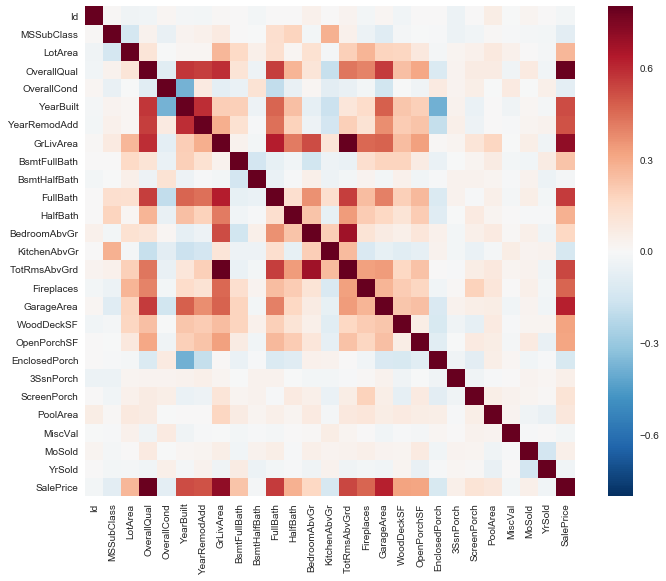

In [12]:
#correlation matrix
corrmat = df_train.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

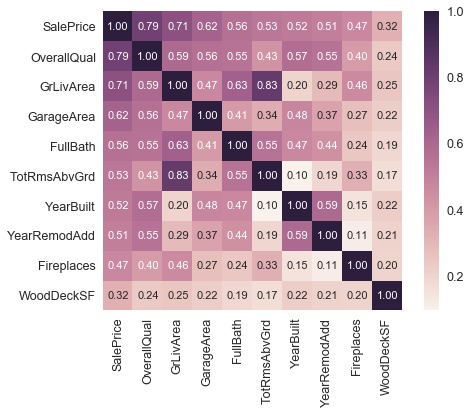

In [13]:
#saleprice correlation matrix
k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index

cm = np.corrcoef(df_train[cols].values.T)

sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 11}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

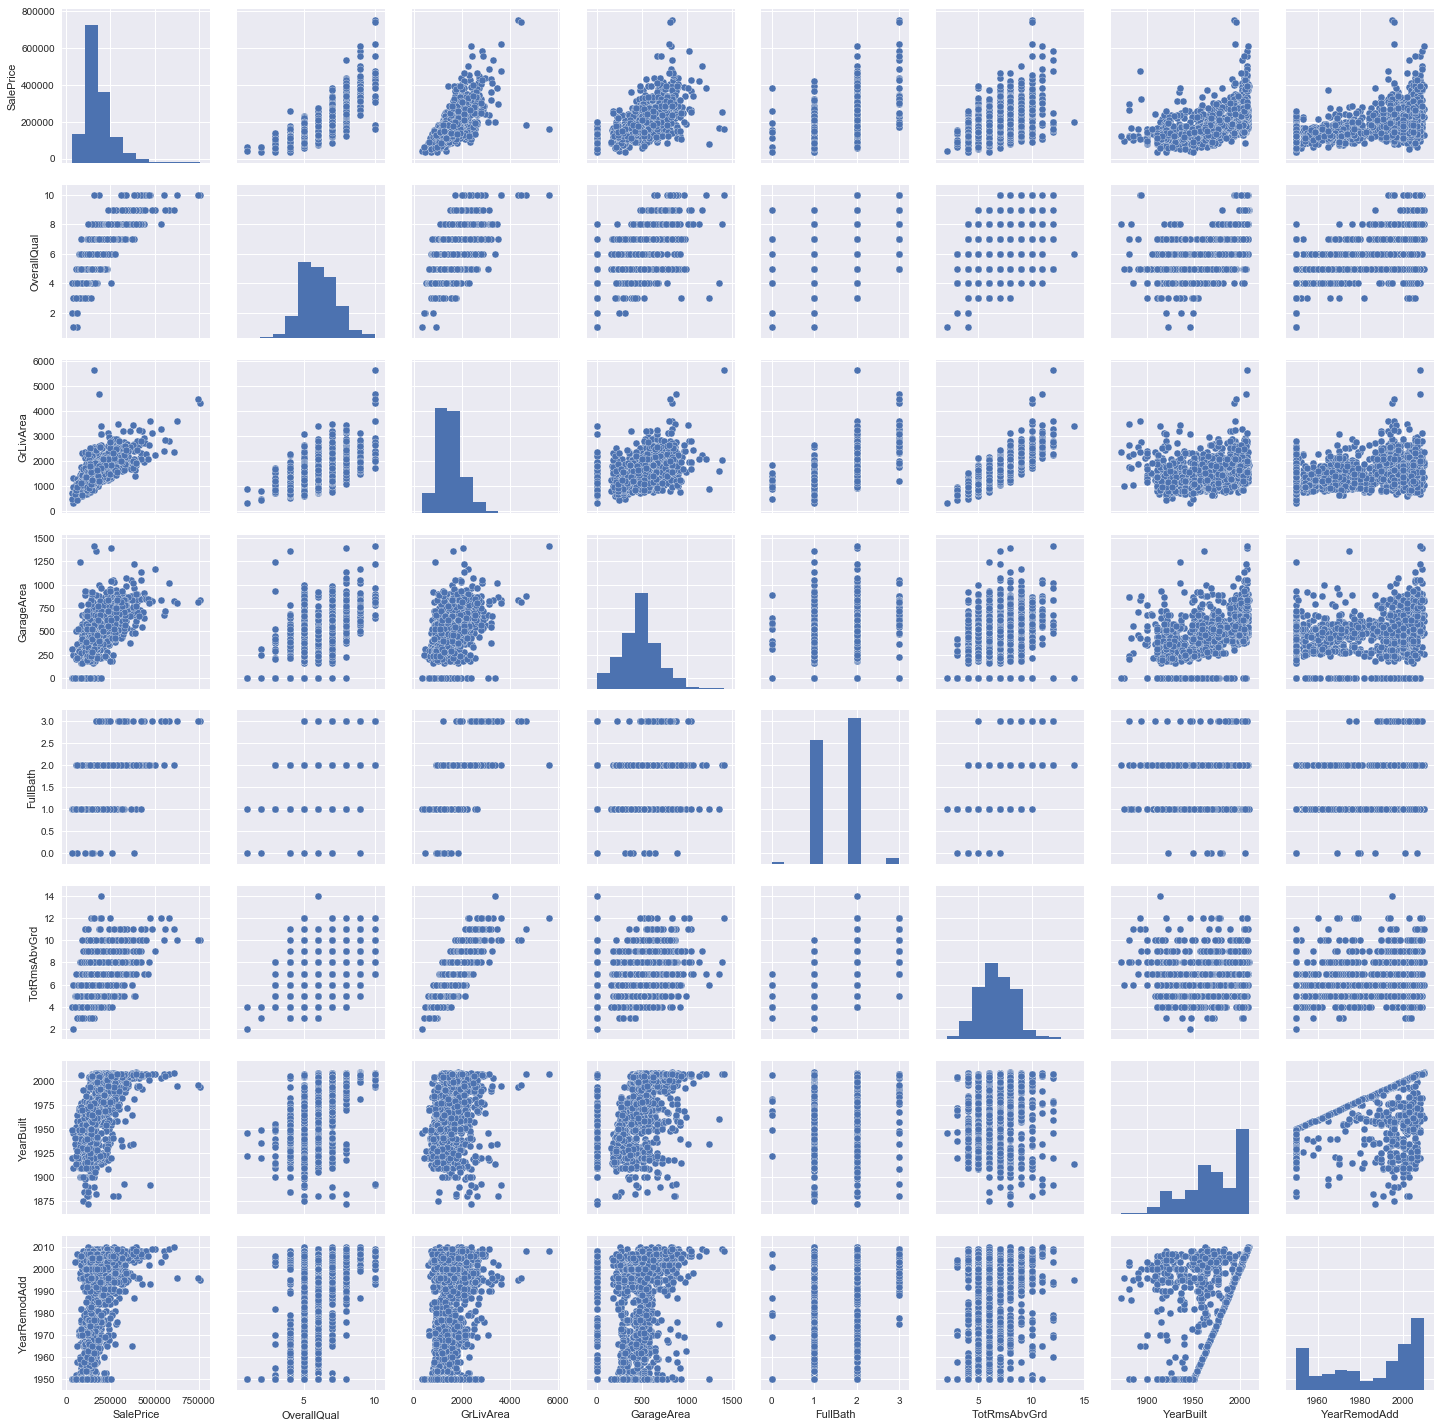

In [14]:

#scatterplot
sns.set()
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageArea', 'FullBath', 'TotRmsAbvGrd', 'YearBuilt', 'YearRemodAdd']
sns.pairplot(df_train[cols], size = 2.5)
plt.show();

## Managing Outliers

Outliers is a complex subject 
http://scikit-learn.org/stable/modules/outlier_detection.html

...but below are a couple of lines of code that could be useful.


https://stackoverflow.com/questions/23199796/detect-and-exclude-outliers-in-pandas-dataframe

1) keep only the ones that are within +3 to -3 standard deviations in the column 'Data'.
df[np.abs(df.Data-df.Data.mean())<=(3*df.Data.std())] 

2) or using Z-score
from scipy import stats
df[(np.abs(stats.zscore(df)) < 3).all(axis=1)]

3) Or using quantile function on each column
For each 
q = df["col"].quantile(0.99)
df[df["col"] < q]



In [15]:
#standardizing data
saleprice_scaled = StandardScaler().fit_transform(df_train['SalePrice'][:,np.newaxis]);
low_range = saleprice_scaled[saleprice_scaled[:,0].argsort()][:10]
high_range= saleprice_scaled[saleprice_scaled[:,0].argsort()][-10:]
print('outer range (low) of the distribution:')
print(low_range)
print('\nouter range (high) of the distribution:')
print(high_range)

outer range (low) of the distribution:
[[-1.83820775]
 [-1.83303414]
 [-1.80044422]
 [-1.78282123]
 [-1.77400974]
 [-1.62295562]
 [-1.6166617 ]
 [-1.58519209]
 [-1.58519209]
 [-1.57269236]]

outer range (high) of the distribution:
[[ 3.82758058]
 [ 4.0395221 ]
 [ 4.49473628]
 [ 4.70872962]
 [ 4.728631  ]
 [ 5.06034585]
 [ 5.42191907]
 [ 5.58987866]
 [ 7.10041987]
 [ 7.22629831]]


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


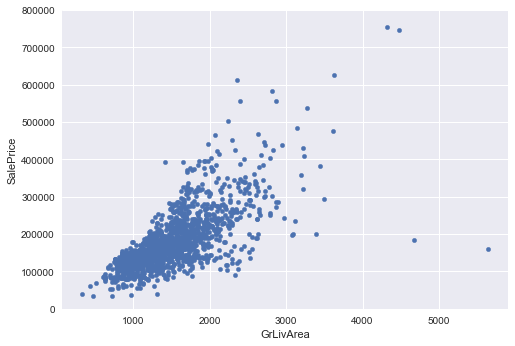

In [16]:
#bivariate analysis saleprice/grlivarea
var = 'GrLivArea'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

Review the use of residuals to manage outliers

In [17]:
#deleting points
df_train.sort_values(by = 'GrLivArea', ascending = False)[:2]
df_train = df_train.drop(df_train[df_train['Id'] == 1299].index)
df_train = df_train.drop(df_train[df_train['Id'] == 524].index)

## More complex pre-processing

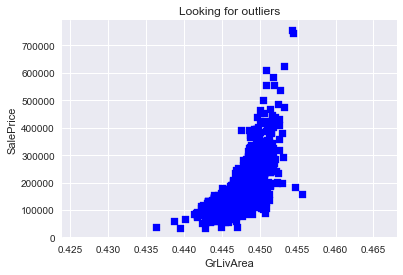

In [173]:
# Looking for outliers, as indicated in https://ww2.amstat.org/publications/jse/v19n3/decock.pdf
plt.scatter(df_train_all.GrLivArea, train.SalePrice, c = "blue", marker = "s")
plt.title("Looking for outliers")
plt.xlabel("GrLivArea")
plt.ylabel("SalePrice")
plt.show()

train = train[train.GrLivArea < 4000]

In [18]:
#bivariate analysis saleprice/grlivarea
#var = 'TotalBsmtSF'
#data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
#data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000))

According to Hair et al. (2013), four assumptions should be tested:

**Normality** - When we talk about normality what we mean is that the data should look like a normal distribution. This is important because several statistic tests rely on this (e.g. t-statistics). In this exercise we'll just check univariate normality for 'SalePrice' (which is a limited approach). Remember that univariate normality doesn't ensure multivariate normality (which is what we would like to have), but it helps. Another detail to take into account is that in big samples (>200 observations) normality is not such an issue. However, if we solve normality, we avoid a lot of other problems (e.g. heteroscedacity) so that's the main reason why we are doing this analysis.

**Homoscedasticity** - refers to the 'assumption that dependent variable(s) exhibit equal levels of variance across the range of predictor variable(s)' (Hair et al., 2013). Homoscedasticity is desirable because we want the error term to be the same across all values of the independent variables.

**Linearity**- The most common way to assess linearity is to examine scatter plots and search for linear patterns. If patterns are not linear, it would be worthwhile to explore data transformations. However, we'll not get into this because most of the scatter plots we've seen appear to have linear relationships.

**Absence of correlated errors** - Correlated errors, like the definition suggests, happen when one error is correlated to another. For instance, if one positive error makes a negative error systematically, it means that there's a relationship between these variables. This occurs often in time series, where some patterns are time related. We'll also not get into this. However, if you detect something, try to add a variable that can explain the effect you're getting. That's the most common solution for correlated errors.

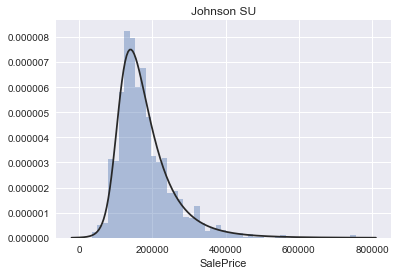

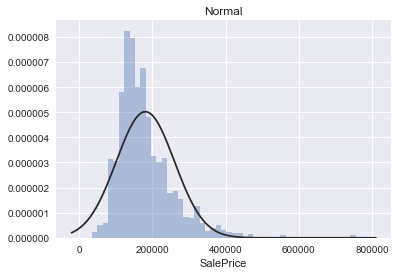

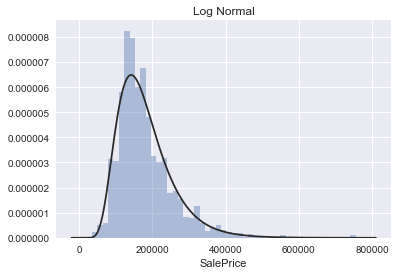

In [144]:
# This demonstrates that Sale price does not follow a normal distribution - see below for different another graph that shows this
y = df_train['SalePrice']
plt.figure(1); plt.title('Johnson SU')
sns.distplot(y, kde=False, fit=st.johnsonsu)
plt.figure(2); plt.title('Normal')
sns.distplot(y, kde=False, fit=st.norm)
plt.figure(3); plt.title('Log Normal')
sns.distplot(y, kde=False, fit=st.lognorm)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


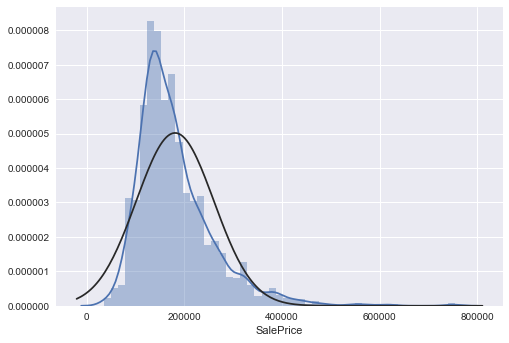

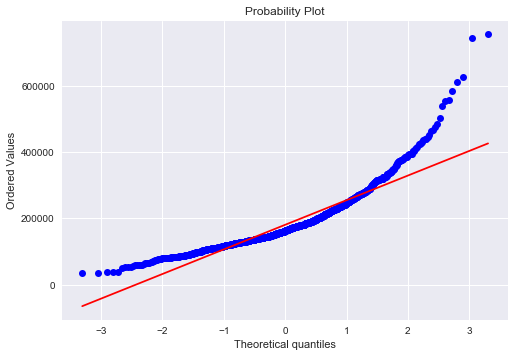

In [19]:
#histogram and normal probability plot
sns.distplot(df_train['SalePrice'], fit=norm);
fig = plt.figure()
res = stats.probplot(df_train['SalePrice'], plot=plt)

In [20]:
#applying log transformation
df_train['SalePrice'] = np.log(df_train['SalePrice'])

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


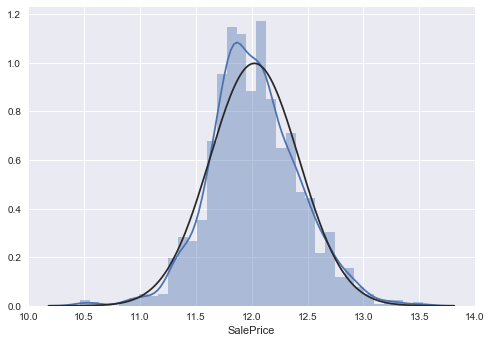

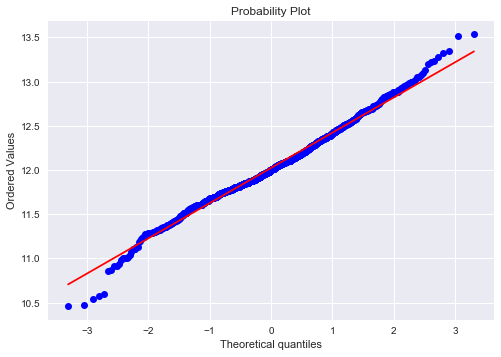

In [21]:
#transformed histogram and normal probability plot
sns.distplot(df_train['SalePrice'], fit=norm);
fig = plt.figure()
res = stats.probplot(df_train['SalePrice'], plot=plt)

It is apparent that SalePrice doesn't follow normal distribution, so before performing regression it has to be transformed. While log transformation does pretty good job, best fit is unbounded Johnson distribution.

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


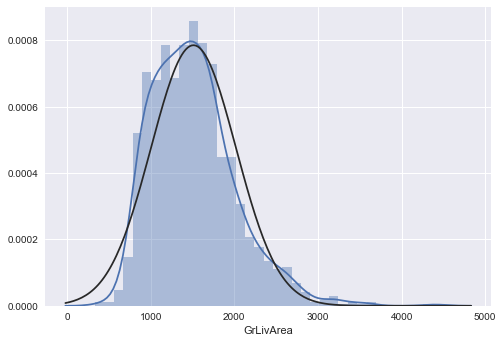

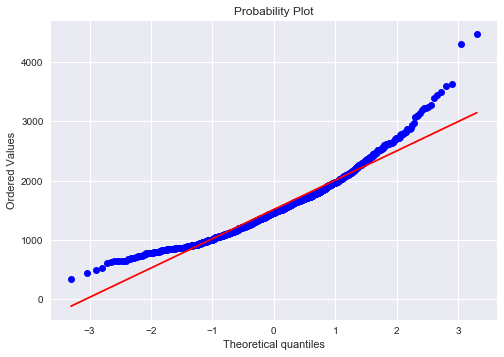

In [22]:
#histogram and normal probability plot
sns.distplot(df_train['GrLivArea'], fit=norm);
fig = plt.figure()
res = stats.probplot(df_train['GrLivArea'], plot=plt)

In [23]:
#data transformation
df_train['GrLivArea'] = np.log(df_train['GrLivArea'])

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


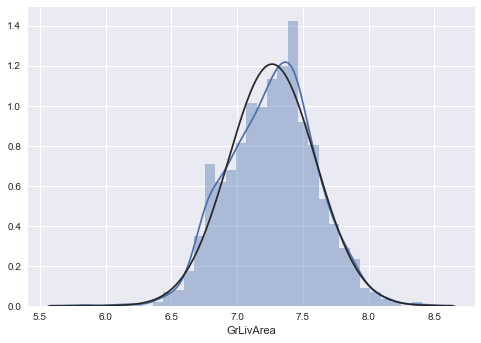

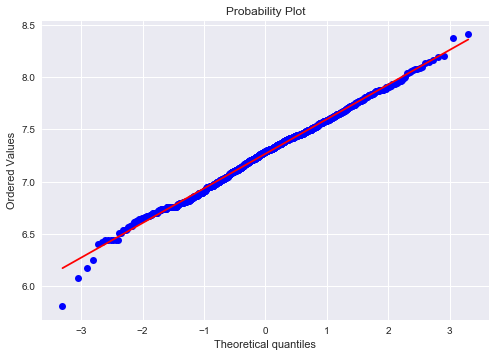

In [24]:
#transformed histogram and normal probability plot
sns.distplot(df_train['GrLivArea'], fit=norm);
fig = plt.figure()
res = stats.probplot(df_train['GrLivArea'], plot=plt)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


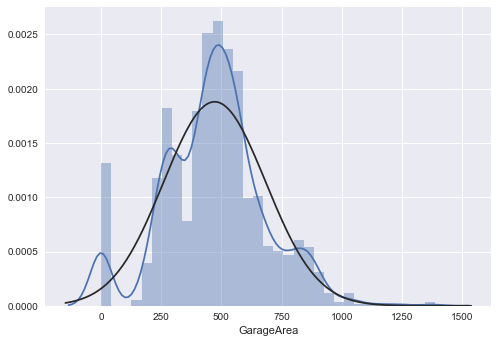

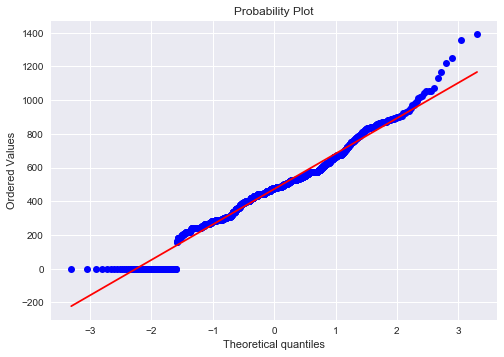

In [25]:
#histogram and normal probability plot
sns.distplot(df_train['GarageArea'], fit=norm);
fig = plt.figure()
res = stats.probplot(df_train['GarageArea'], plot=plt)

In [26]:
#create column for new variable (one is enough because it's a binary categorical feature)
#if area>0 it gets 1, for area==0 it gets 0
#df_train['HasBsmt'] = pd.Series(len(df_train['TotalBsmtSF']), index=df_train.index)
#df_train['HasBsmt'] = 0 
#df_train.loc[df_train['TotalBsmtSF']>0,'HasBsmt'] = 1

In [27]:
#transform data
#df_train.loc[df_train['HasBsmt']==1,'TotalBsmtSF'] = np.log(df_train['TotalBsmtSF'])

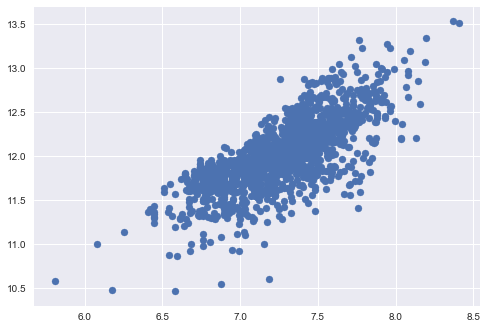

In [28]:
#scatter plot
plt.scatter(df_train['GrLivArea'], df_train['SalePrice']);

In [148]:
# Test it any of the quantitative variables follow a normal distribution
# https://docs.scipy.org/doc/scipy-0.19.0/reference/generated/scipy.stats.shapiro.html
# This performs the Shapiro-WIlkes test for normality on the categorical varaibles
test_normality = lambda x: stats.shapiro(x.fillna(0))[1] < 0.01
normal = pd.DataFrame(df_train_all[quantitative])
normal = normal.apply(test_normality)
print(not normal.any())
# The false result means none of the variables are normal

False


So these need normalised before the modelling
https://pandas.pydata.org/pandas-docs/stable/generated/pandas.melt.html
This essentially give the qualitative variables in the first Column and the associated values in the second column

Some independent varia"bles look like good candidates for log transformation: TotalBsmtSF, KitchenAbvGr, LotFrontage, LotArea and others. While ganining on regression transformation will smooth out some irregularities which could be important like large amount of houses with 0 2ndFlrSF. Such irregularities are good candidates for feature construction."

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


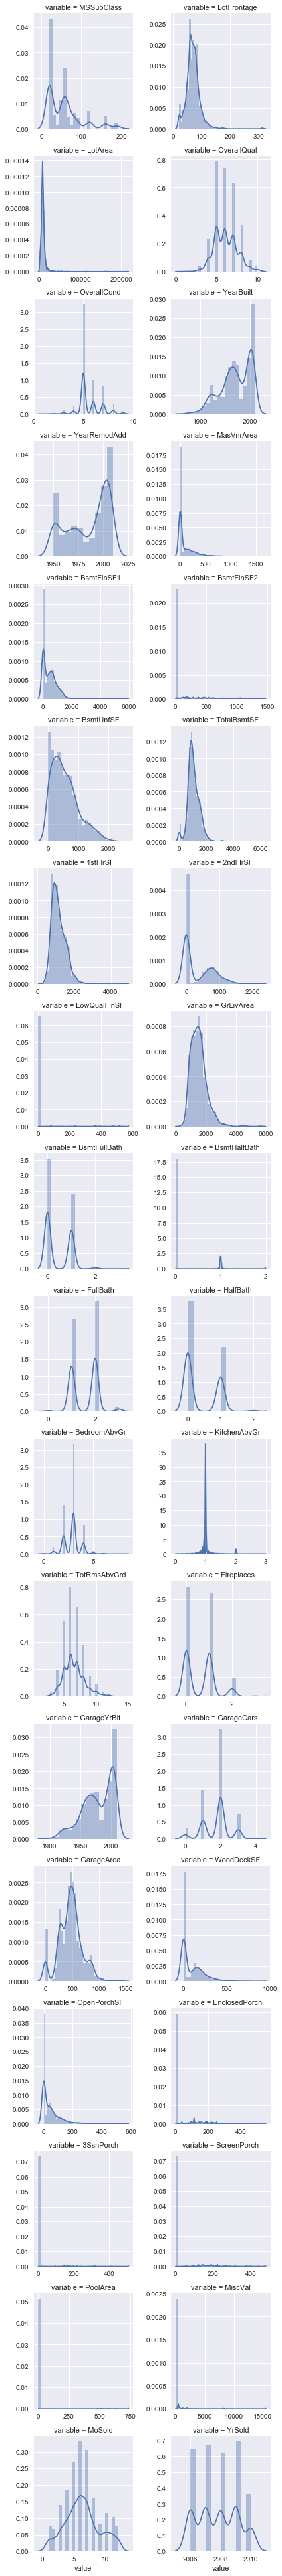

In [151]:
f = pd.melt(df_train_all, value_vars=quantitative)
g = sns.FacetGrid(f, col="variable",  col_wrap=2, sharex=False, sharey=False)
g = g.map(sns.distplot, "value")

## Categorical Variables
https://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.cat.add_categories.html

With qualitative variables we can implement two methods. First one is to check distribution of SalePrice with respect to variable values and enumerate them. Second to create dummy variable for each possible category.

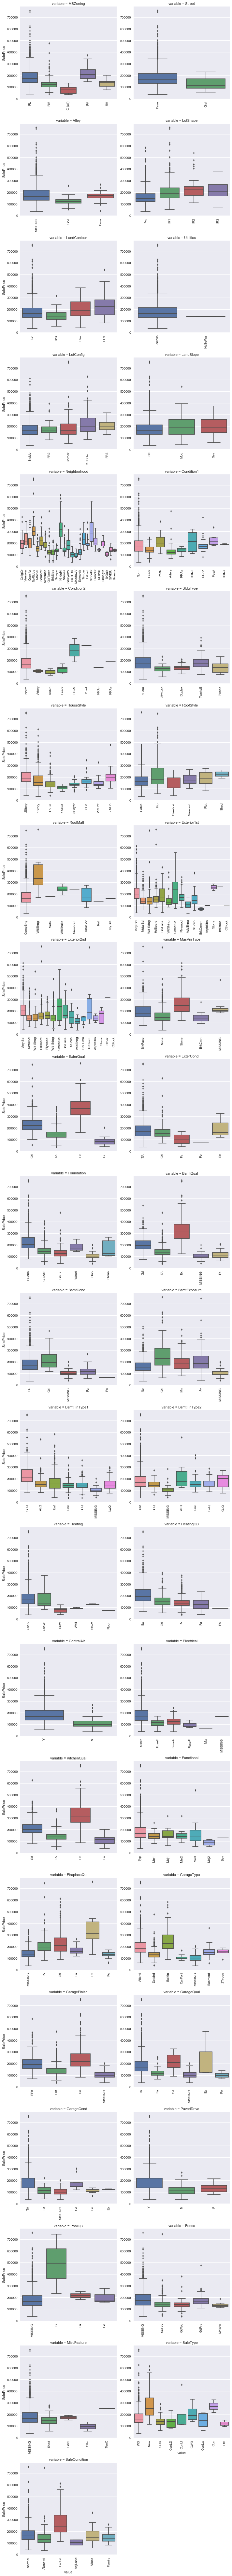

In [154]:
for c in qualitative:
    df_train_all[c] = df_train_all[c].astype('category')
    if df_train_all[c].isnull().any():
        df_train_all[c] = df_train_all[c].cat.add_categories(['MISSING'])
        df_train_all[c] = df_train_all[c].fillna('MISSING')

def boxplot(x, y, **kwargs):
    sns.boxplot(x=x, y=y)
    x=plt.xticks(rotation=90)
f = pd.melt(df_train_all, id_vars=['SalePrice'], value_vars=qualitative)
g = sns.FacetGrid(f, col="variable",  col_wrap=2, sharex=False, sharey=False, size=5)
g = g.map(boxplot, "value", "SalePrice")

### ANOVA
Is the analysis of the variance in SalesPrice and how this affected by the variables
The one-way ANOVA compares the means between the groups you are interested in and determines whether any of those means are statistically significantly different from each other

Here is quick estimation of influence of categorical variable on SalePrice. For each variable SalePrice are partitioned to distinct sets based on category values. Then check with ANOVA test if sets have similar distributions. If variable has minor impact then set means should be equal. Decreasing pval is sign of increasing diversity in partitions.

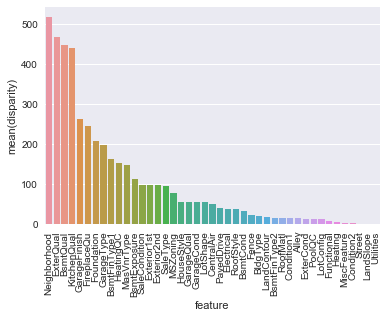

In [156]:
def anova(frame):
    anv = pd.DataFrame()
    anv['feature'] = qualitative
    pvals = []
    for c in qualitative:
        samples = []
        for cls in frame[c].unique():
            s = frame[frame[c] == cls]['SalePrice'].values
            samples.append(s)
        pval = stats.f_oneway(*samples)[1]
        pvals.append(pval)
    anv['pval'] = pvals
    return anv.sort_values('pval')

a = anova(df_train_all)
a['disparity'] = np.log(1./a['pval'].values)
sns.barplot(data=a, x='feature', y='disparity')
x=plt.xticks(rotation=90)

In [158]:
def encode(frame, feature):
    ordering = pd.DataFrame()
    ordering['val'] = frame[feature].unique()
    ordering.index = ordering.val
    ordering['spmean'] = frame[[feature, 'SalePrice']].groupby(feature).mean()['SalePrice']
    ordering = ordering.sort_values('spmean')
    ordering['ordering'] = range(1, ordering.shape[0]+1)
    ordering = ordering['ordering'].to_dict()
    
    for cat, o in ordering.items():
        frame.loc[frame[feature] == cat, feature+'_E'] = o
    
qual_encoded = []
for q in qualitative:  
    encode(df_train_all, q)
    qual_encoded.append(q+'_E')
print(qual_encoded)

['MSZoning_E', 'Street_E', 'Alley_E', 'LotShape_E', 'LandContour_E', 'Utilities_E', 'LotConfig_E', 'LandSlope_E', 'Neighborhood_E', 'Condition1_E', 'Condition2_E', 'BldgType_E', 'HouseStyle_E', 'RoofStyle_E', 'RoofMatl_E', 'Exterior1st_E', 'Exterior2nd_E', 'MasVnrType_E', 'ExterQual_E', 'ExterCond_E', 'Foundation_E', 'BsmtQual_E', 'BsmtCond_E', 'BsmtExposure_E', 'BsmtFinType1_E', 'BsmtFinType2_E', 'Heating_E', 'HeatingQC_E', 'CentralAir_E', 'Electrical_E', 'KitchenQual_E', 'Functional_E', 'FireplaceQu_E', 'GarageType_E', 'GarageFinish_E', 'GarageQual_E', 'GarageCond_E', 'PavedDrive_E', 'PoolQC_E', 'Fence_E', 'MiscFeature_E', 'SaleType_E', 'SaleCondition_E']


## Other Correlations 

Generally to reduce confunding only variables uncorrelated with each other should be added to regression models (which are correlated with SalePrice).
Spearman correlation is better to work with in this case because it picks up relationships between variables even when they are nonlinear. OverallQual is main criterion in establishing house price. Neighborhood has big influence, partially it has some intrisinc value in itself, but also houses in certain regions tend to share same characteristics (confunding) what causes similar valuations.

https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.corr.html
* Pearson Correlation - Mostly wide used. Measures linear correlation between continuous variables

* Kendall Correlation - Kendalls' τ does not take into account the difference between ranks — only directional agreement. Therefore, this coefficient is more appropriate for discrete data.

* Spearman Correlation - Special case of Pearson applied to ranked variables. It measures monotonic association (only strictly increasing or decreasing, but not mixed) between two variables and relies on the rank order of values. In other words, rather than comparing means and variances, Spearman's coefficient looks at the relative order of values for each variable. This makes it appropriate to use with both continuous and discrete data.

https://www.datascience.com/blog/introduction-to-correlation-learn-data-science-tutorials

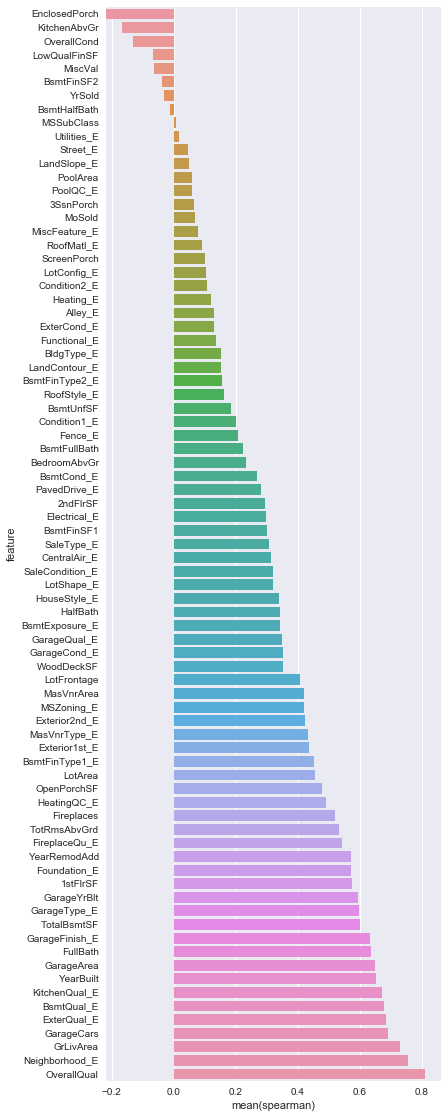

In [159]:
def spearman(frame, features):
    spr = pd.DataFrame()
    spr['feature'] = features
    spr['spearman'] = [frame[f].corr(frame['SalePrice'], 'spearman') for f in features]
    spr = spr.sort_values('spearman')
    plt.figure(figsize=(6, 0.25*len(features)))
    sns.barplot(data=spr, y='feature', x='spearman', orient='h')
    
features = quantitative + qual_encoded
spearman(df_train_all, features)

There are many strong correlations between variables. Garages seem to be built same year as houses, basements have generally same area as first floor which is pretty obvious. Garage area is strongly correlated with number of cars. Neighborhood is correlated with lots of other variables and this confirms the idea that houses in same region share same characteristics. Dwelling type is negatively correlated with kitchen above grade square feet

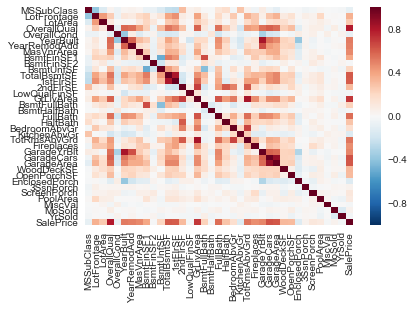

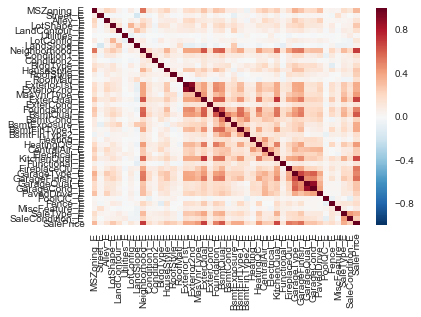

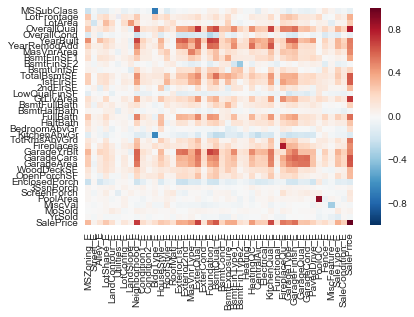

In [161]:
plt.figure(1)
corr = df_train_all[quantitative+['SalePrice']].corr()
sns.heatmap(corr)
plt.figure(2)
corr = df_train_all[qual_encoded+['SalePrice']].corr()
sns.heatmap(corr)
plt.figure(3)
corr = pd.DataFrame(np.zeros([len(quantitative)+1, len(qual_encoded)+1]), index=quantitative+['SalePrice'], columns=qual_encoded+['SalePrice'])
for q1 in quantitative+['SalePrice']:
    for q2 in qual_encoded+['SalePrice']:
        corr.loc[q1, q2] = df_train_all[q1].corr(df_train_all[q2])
sns.heatmap(corr)

## Pair Plots
It also would be useful to see how sale price compares to each independent variable.

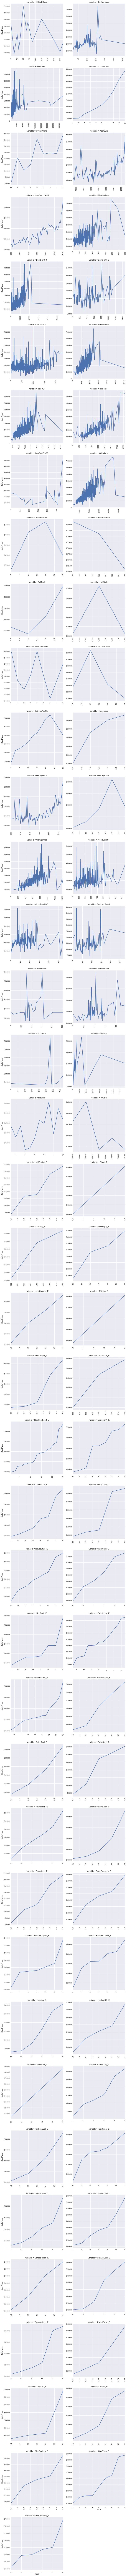

In [163]:
def pairplot(x, y, **kwargs):
    ax = plt.gca()
    ts = pd.DataFrame({'time': x, 'val': y})
    ts = ts.groupby('time').mean()
    ts.plot(ax=ax)
    plt.xticks(rotation=90)
    
f = pd.melt(df_train_all, id_vars=['SalePrice'], value_vars=quantitative+qual_encoded)
g = sns.FacetGrid(f, col="variable",  col_wrap=2, sharex=False, sharey=False, size=5)
g = g.map(pairplot, "value", "SalePrice")

## Price Segments
It is possible that correlations shift with change of SalePrice.

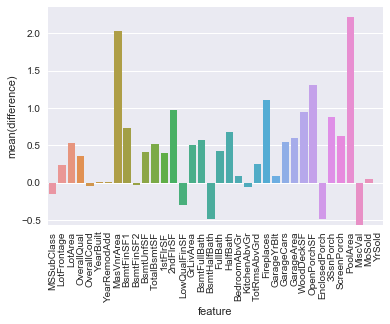

In [165]:
features = quantitative

standard = df_train_all[df_train_all['SalePrice'] < 200000]
pricey = df_train_all[df_train_all['SalePrice'] >= 200000]

diff = pd.DataFrame()
diff['feature'] = features
diff['difference'] = [(pricey[f].fillna(0.).mean() - standard[f].fillna(0.).mean())/(standard[f].fillna(0.).mean())
                      for f in features]

sns.barplot(data=diff, x='feature', y='difference')
x=plt.xticks(rotation=90)

In [119]:
#convert categorical variable into dummy
df_train = pd.get_dummies(df_train)

# Create dataframes that can be passed to the fit
df_predictor = df_train['SalePrice']
df_feature = df_train[['OverallQual','GrLivArea','GarageArea','FullBath', 'TotRmsAbvGrd', 'YearBuilt', 'YearRemodAdd']]

In [120]:
model = LinearRegression(fit_intercept=True, normalize=False, copy_X=True, n_jobs=1)
model.fit(df_feature,df_predictor)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [121]:
# Read in the test data
df_test = pd.read_csv('C:/Users/Admin/Documents/Kaggle/HousePriceRegression/test.csv')

df_testfeatures = df_test[['Id', 'OverallQual','GrLivArea','GarageArea','FullBath', 'TotRmsAbvGrd', 'YearBuilt', 'YearRemodAdd']]

#data transformation
df_testfeatures['GrLivArea'] = np.log(df_testfeatures['GrLivArea'])

#missing data
total = df_testfeatures.isnull().sum().sort_values(ascending=False)
percent = (df_testfeatures.isnull().sum()/df_testfeatures.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

#dealing with missing data
df_testfeatures = df_testfeatures.drop(df_testfeatures.loc[df_testfeatures['GarageArea'].isnull()].index)
df_testfeatures.isnull().sum().max() #just checking that there's no missing data missing...

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


0

In [131]:
df_testfeatures = df_testfeatures[['OverallQual','GrLivArea','GarageArea','FullBath', 'TotRmsAbvGrd', 'YearBuilt', 'YearRemodAdd']]

predicted_saleprice = model.predict(df_testfeatures) 

predicted_saleprice_exp = np.exp(predicted_saleprice)

saleprice = pd.DataFrame({'SalePrice' : pd.Series(list(predicted_saleprice_exp))})

submission = pd.concat([somedf['Id'], saleprice['SalePrice']], axis=1)

submission.head()

df_train['SalePrice'].describe
submission['SalePrice'].describe()
# submission.to_csv('C:/Users/Admin/Documents/Kaggle/HousePriceRegression/Submission.csv', index = False)

count      1458.000000
mean     177209.938381
std       69636.765830
min       49691.147572
25%      125189.497549
50%      159198.764594
75%      213838.794973
max      640821.469126
Name: SalePrice, dtype: float64

## More Advanced Regression
What are the types of Regressions?
Linear Regression
Logistic Regression
Polynomial Regression
Stepwise Regression
Ridge Regression
Lasso Regression - Least Absolute Shrinkage and Selection Operator
ElasticNet Regression
https://www.analyticsvidhya.com/blog/2015/08/comprehensive-guide-regression/

In [172]:
def error(actual, predicted):
    actual = np.log(actual)
    predicted = np.log(predicted)
    return np.sqrt(np.sum(np.square(actual-predicted))/len(actual))

def log_transform(feature):
    train[feature] = np.log1p(train[feature].values)

def quadratic(feature):
    train[feature+'2'] = train[feature]**2

train = df_train_all    
    
log_transform('GrLivArea')
log_transform('1stFlrSF')
log_transform('2ndFlrSF')
log_transform('TotalBsmtSF')
log_transform('LotArea')
log_transform('LotFrontage')
log_transform('KitchenAbvGr')
log_transform('GarageArea')

quadratic('OverallQual')
quadratic('YearBuilt')
quadratic('YearRemodAdd')
quadratic('TotalBsmtSF')
quadratic('2ndFlrSF')
quadratic('Neighborhood_E')
quadratic('RoofMatl_E')
quadratic('GrLivArea')

qdr = ['OverallQual2', 'YearBuilt2', 'YearRemodAdd2', 'TotalBsmtSF2',
        '2ndFlrSF2', 'Neighborhood_E2', 'RoofMatl_E2', 'GrLivArea2']

train['HasBasement'] = train['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
train['HasGarage'] = train['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
train['Has2ndFloor'] = train['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
train['HasMasVnr'] = train['MasVnrArea'].apply(lambda x: 1 if x > 0 else 0)
train['HasWoodDeck'] = train['WoodDeckSF'].apply(lambda x: 1 if x > 0 else 0)
train['HasPorch'] = train['OpenPorchSF'].apply(lambda x: 1 if x > 0 else 0)
train['HasPool'] = train['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
train['IsNew'] = train['YearBuilt'].apply(lambda x: 1 if x > 2000 else 0)

boolean = ['HasBasement', 'HasGarage', 'Has2ndFloor', 'HasMasVnr', 'HasWoodDeck',
            'HasPorch', 'HasPool', 'IsNew']


features = quantitative + qual_encoded + boolean + qdr
lasso = linear_model.LassoLarsCV(max_iter=10000)
X = train[features].fillna(0.).values
Y = train['SalePrice'].values
lasso.fit(X, np.log(Y))

Ypred = np.exp(lasso.predict(X))
error(Y, Ypred)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:334: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 102 iterations, alpha=1.029e-03, previous alpha=7.360e-06, with an active set of 81 regressors.
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:334: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 105 iterations, alpha=1.158e-04, previous alpha=6.972e-06, with an active set of 80 regressors.
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:334: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 99 iterations, alpha=1.151e-03, previous alpha=6.699e-07, with an active set of 88 regressors.
  Conv

0.11990486459688693